In [5]:
# Libraries 

import math
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from scipy.optimize import fsolve

import sys

from random import random

import OpenGL
from OpenGL.GL import *
from OpenGL.GLU import *
import OpenGL.GL as gl
import OpenGL.GLU as glu
import OpenGL.GLUT as glut

import csv
import pywavefront
import pygame
from pygame.locals import *

In [6]:
# Model File Loader
class model_file_loader:
    
    def __init__(self):
        self.vertex_coordinates = []
        self.vertex_index = []
        self.part = 0
        
    def load_model(self,file):
        line_counter = 0
        line_index_array = []
        
        for line in open(file,'r'):
            line_counter = line_counter + 1
            values = line.split()
            
            if ((len(values) > 1) and (values[1] == 'object')):
                self.part = self.part+1
                line_index_array.append(line_counter)
        
        part=[]
        part_index=[[] for i in range(self.part)]
        k=0
        w=0
        
        for line in open(file,'r'):
            values = line.split()
            k = k + 1
            
            if len(values) > 1 and values[0] == 'v':
                part.append(tuple([float(t) for t in values[1:4]]))
                
            if ((line_index_array[w] < k) and (k < line_index_array[w+1]) and (w < self.part-1)):
                if len(values) > 1 and values[0] == 'f':
                    part_index[w].append(tuple([int(t)-1 for t in values[1:4]]))
                    
            if k == line_index_array[w+1] and w+1 < self.part-1:
                w = w + 1
                continue
                
            if k > line_index_array[self.part-1]:
                if len(values) > 1 and values[0] == 'f':
                    part_index[self.part-1].append(tuple([int(t)-1 for t in values[1:4]]))
                    
        self.vertex_coordinates = tuple(part)
        self.vertex_index = tuple([tuple(part_index[i]) for i in range(self.part)])
        
        
obj = model_file_loader()
obj.load_model('new_model3.obj')
vertices = obj.vertex_coordinates
edges = obj.vertex_index
parts = obj.part

In [7]:
#.csv File Opening, Reading and Writing to Array

with open('coefficients.csv', newline='') as f:
    line_array = []
    reader = csv.reader(f)
    for row in reader:
        line=[x for x in ';'.join(row).split(';')]
        line_array.append(line)

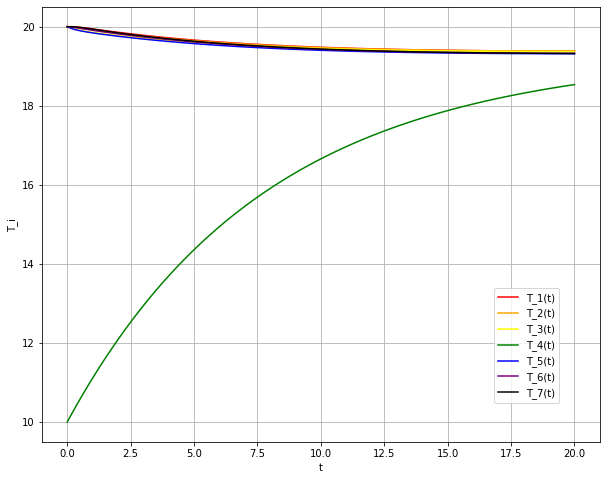

In [8]:
# Task ODE System (in progress...)

# ----- DELETE ------
eps = np.array([0.05,0.05,0.05,0.1,0.05,0.05,0.05])
c = np.array([900,900,900,520,900,900,900])

lyambda = np.zeros((7,7))
lyambda[0][1] = 240
lyambda[1][2] = 240
lyambda[2][3] = 9.7
lyambda[3][4] = 10.5
lyambda[4][5] = 240
lyambda[5][6] = 240

A = 1
# ----- DELETE ------

c_zero = 5.67

#section_area #S_ij 
section_area = np.zeros((7,7))
section_area[0][1] = 12.25
section_area[1][2] = 12.25
section_area[2][3] = 3.06
section_area[3][4] = 3.06
section_area[4][5] = 12.25
section_area[5][6] = 12.25 

#k_ij = lyambda_ij * S_ij
k = np.zeros((7,7))
k[0][1] = lyambda[0][1] * section_area[0][1]
k[1][2] = lyambda[1][2] * section_area[1][2]
k[2][3] = lyambda[2][3] * section_area[2][3]
k[3][4] = lyambda[3][4] * section_area[3][4]
k[4][5] = lyambda[4][5] * section_area[4][5]
k[5][6] = lyambda[5][6] * section_area[5][6] 

element_surface_area = np.array([36.17,99.41,48.53,248.00,48.53,99.41,36.17]) #S_i 

def heat_flow_1(t): #Q_2^R
    return A * (22 + 2 * np.sin(t/8))

def heat_flow_5(t): #Q_6^R
    return A * (22 + 2 * np.sin(t/6)) 

def ode_system(temperature, time):
    T0 = temperature[0]
    T1 = temperature[1]
    T2 = temperature[2]
    T3 = temperature[3]
    T4 = temperature[4]
    T5 = temperature[5]
    T6 = temperature[6]

    right_function=np.empty(7)

    right_function[0] = (-k[0][1] * (T0-T1) - eps[0] * element_surface_area[0] * c_zero * ((T0/100)**4))/c[0]
    right_function[1] = (-k[0][1] * (T1-T0) - k[1][2] * (T1-T2) - eps[1] * element_surface_area[1] * c_zero * ((T1/100)**4) + heat_flow_1(time))/c[1]
    right_function[2] = (-k[1][2] * (T2-T1) - k[2][3] * (T2-T3) - eps[2] * element_surface_area[2] * c_zero * ((T2/100)**4))/c[2] 
    right_function[3] = (-k[2][3] * (T3-T2) - k[3][4] * (T3-T4) - eps[3] * element_surface_area[3] * c_zero * ((T3/100)**4) )/c[3]  
    right_function[4] = (-k[3][4] * (T4-T3) - k[4][5] * (T4-T5) - eps[4] * element_surface_area[4] * c_zero * ((T4/100)**4) )/c[4] 
    right_function[5] = (-k[4][5] * (T5-T4) - k[5][6] * (T5-T6) - eps[5] * element_surface_area[5] * c_zero * ((T5/100)**4) + heat_flow_5(time))/c[5] 
    right_function[6] = (-k[5][6] * (T6-T5) - eps[6] * element_surface_area[6] * c_zero * ((T6/100)**4))/c[6] 
    
    return(right_function)

time = np.linspace(0,20,100)
initial_conditions = np.array([20,20,20,10,20,20,20])
ode_system_solution = odeint(ode_system, initial_conditions, time)

plt.rcParams['figure.figsize'] = [10, 8]
plt.grid(True)
plt.xlabel('t')
plt.ylabel('T_i')
plt.plot(time, ode_system_solution[:,0], color='red', label = "T_1(t)")
plt.plot(time, ode_system_solution[:,1], color='orange', label = "T_2(t)")
plt.plot(time, ode_system_solution[:,2], color='yellow', label = "T_3(t)")
plt.plot(time, ode_system_solution[:,3], color='green', label = "T_4(t)")
plt.plot(time, ode_system_solution[:,4], color='blue', label = "T_5(t)")
plt.plot(time, ode_system_solution[:,5], color='purple', label = "T_6(t)")
plt.plot(time, ode_system_solution[:,6], color='black', label = "T_7(t)")
plt.legend(bbox_to_anchor = (0.85, 0.4), bbox_transform = plt.gcf().transFigure)
plt.show()

In [ ]:
# Model Import

scene = pywavefront.Wavefront('new_model3.obj', collect_faces=True)

scene_box = (scene.vertices[0], scene.vertices[0])
for vertex in scene.vertices:
    min_v = [min(scene_box[0][i], vertex[i]) for i in range(3)]
    max_v = [max(scene_box[1][i], vertex[i]) for i in range(3)]
    scene_box = (min_v, max_v)

scene_size     = [scene_box[1][i]-scene_box[0][i] for i in range(3)]
max_scene_size = max(scene_size)
scaled_size    = 5
scene_scale    = [scaled_size/max_scene_size for i in range(3)]
scene_trans    = [-(scene_box[1][i]+scene_box[0][i])/2 for i in range(3)]

colors=((0.5,0,0),(0,0.5,0),(0,0,0.5),(1,0,0),(0,1,0),(1,0,1),(1,0,1),(1,0.5,0))

def Model():
    glPushMatrix()
    glScalef(*scene_scale)
    glTranslatef(*scene_trans)

    for mesh in scene.mesh_list:
        glBegin(GL_TRIANGLES)
        for g in range(parts):
            for edge in edges[g]:
                for vertex in edge:
                    glColor3fv(colors[g])
                    glVertex3fv(vertices[vertex])
        glEnd()

    glPopMatrix()

def main():
        pygame.init()
        display = (800, 600)
        pygame.display.set_mode(display, DOUBLEBUF | OPENGL)
        gluPerspective(42, (display[0] / display[1]), 0.1, 50.0)
        glTranslatef(0.0, 0.0, -10)

        while True:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    sys.exit()
                    break

                if event.type == pygame.KEYDOWN:
                    if event.key == pygame.K_LEFT:
                        glTranslatef(-0.5,0,0)
                    if event.key == pygame.K_RIGHT:
                        glTranslatef(0.5,0,0)
                    if event.key == pygame.K_UP:
                        glTranslatef(0,1,0)
                    if event.key == pygame.K_DOWN:
                        glTranslatef(0,-1,0)

            glRotatef(10, 1, 1, 1)
            glClearColor(0.1,0.1,0.1,0)
            glClear(GL_COLOR_BUFFER_BIT|GL_DEPTH_BUFFER_BIT)
            
            glEnable(GL_DEPTH_TEST);
            glDepthFunc(GL_LESS);

            #glPolygonMode(GL_FRONT_AND_BACK, GL_LINE)
            Model()
            glPolygonMode(GL_FRONT_AND_BACK, GL_FILL)

            pygame.display.flip()
            pygame.time.wait(10)

main()

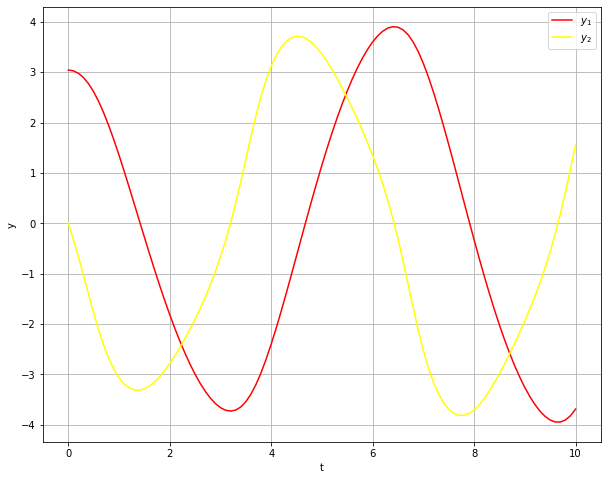

In [9]:
# ODE Solving Example (from lesson)
def sys_of_funcs(y, t, b, c):
    y1 = y[0]
    y2 = y[1]
    f1 = y2
    f2 = - b * y1 - c * np.sin(y2) 
    return [f1, f2]

init = np.pi - 0.1, 0.0 
t = np.linspace(0, 10, 101)
b = 1
c = -1
sol = odeint(sys_of_funcs, init, t, args=(b, c))

plt.grid()
plt.xlabel('t')
plt.ylabel('y')
plt.plot(t, sol[:, 0], color='red', label=r"$y_1$")
plt.plot(t, sol[:, 1], color='yellow', label=r"$y_2$")
plt.legend(loc="best")
plt.show()

In [ ]:
#OpenGL Example (from lesson)

pointdata = [[0, 0.5, 0], 
             [-0.5, -0.5, 0], 
             [0.5, -0.5, 0]]

pointcolor = [[1, 1, 0], 
              [0, 1, 1], 
              [1, 0, 1]]

vertex_source = """
varying vec4 vertex_color;
void main(){
    gl_Position = gl_ModelViewProjectionMatrix * gl_Vertex;
    vertex_color = gl_Color;
}
"""

fragment_source = """
varying vec4 vertex_color;
void main() {
    gl_FragColor = vertex_color;
}
"""

def create_shader(sh_type, sh_source):
    sh = gl.glCreateShader(sh_type)
    gl.glShaderSource(sh, sh_source)
    gl.glCompileShader(sh)
    return sh

def display():
    gl.glClear(gl.GL_COLOR_BUFFER_BIT)
    gl.glEnableClientState(gl.GL_VERTEX_ARRAY)
    gl.glEnableClientState(gl.GL_COLOR_ARRAY)
    gl.glVertexPointer(3, gl.GL_FLOAT, 0, pointdata)
    gl.glColorPointer(3, gl.GL_FLOAT, 0, pointcolor)
    gl.glDrawArrays(gl.GL_TRIANGLES, 0, 3)
    gl.glDisableClientState(gl.GL_VERTEX_ARRAY)
    gl.glDisableClientState(gl.GL_COLOR_ARRAY)
    glut.glutSwapBuffers()
    
def specialkeys(key, x, y):
    global pointcolor
    if key == glut.GLUT_KEY_UP:
        gl.glRotatef(5, 1, 0, 0)
    if key == glut.GLUT_KEY_DOWN:
        gl.glRotatef(-5, 1, 0, 0)
    if key == glut.GLUT_KEY_LEFT:
        gl.glRotatef(5, 0, 1, 0)
    if key == glut.GLUT_KEY_RIGHT:
        gl.glRotatef(-5, 0, 1, 0)
    if key == glut.GLUT_KEY_END:
        pointcolor = [[random(), random(), random()], 
                      [random(), random(), random()], 
                      [random(), random(), random()]]

def initialize():
    vertex = create_shader(gl.GL_VERTEX_SHADER, vertex_source)
    fragment = create_shader(gl.GL_FRAGMENT_SHADER, fragment_source)
    
    program = gl.glCreateProgram()
    gl.glAttachShader(program, vertex)
    gl.glAttachShader(program, fragment)
    gl.glLinkProgram(program)
    gl.glUseProgram(program)


def run():
    glut.glutInit(sys.argv)
    glut.glutInitDisplayMode(glut.GLUT_DOUBLE | glut.GLUT_RGB)
    glut.glutInitWindowSize(640, 480)
    glut.glutInitWindowPosition(50, 50)
    window = glut.glutCreateWindow("Example")
    glut.glutDisplayFunc(display)
    glut.glutIdleFunc(display)
    glut.glutSpecialFunc(specialkeys)
    gl.glClearColor(0.2, 0.2, 0.2, 1)
    
    try:
        initialize()
    except:
        print("Error")
        
    glut.glutMainLoop()
    
print("Press `End` to change color")

run()